<a href="https://colab.research.google.com/github/AlexKI123/OnlineChallengeStockMarket/blob/main/LSTM_with_CyclicalLearningRates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping
import math

class CustomCLR(Callback):
    # Constructor to initialize the callback with required parameters.
    def __init__(self, base_lr, max_lr, total_iterations, step_size, final_decay_factor=0.1):
        super(CustomCLR, self).__init__()  # Call the parent class constructor
        self.base_lr = base_lr  # Starting learning rate
        self.max_lr = max_lr  # Maximum learning rate
        self.total_iterations = total_iterations  # Total number of iterations for the training
        self.step_size = step_size  # Number of iterations for half of the cycle
        self.final_decay_factor = final_decay_factor  # Factor for the final learning rate decrease
        self.clr_iterations = 0  # Counter for iterations
        self.history = {}  # History for learning rates

    # Method called at the beginning of training to set the initial learning rate.
    def on_train_begin(self, logs=None):
        logs = logs or {}  # Ensure logs is a dictionary
        K.set_value(self.model.optimizer.lr, self.base_lr)  # Set the optimizer's learning rate to base_lr

    # Method called after each batch to update the learning rate.
    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.clr_iterations += 1
        if self.clr_iterations >=  2*self.step_size:
            # Last epoch: linear decrease to one magnitude smaller than base_lr
            final_lr = self.base_lr * self.final_decay_factor
            progress = (self.clr_iterations - (self.total_iterations - 2*self.step_size)) / (2*self.step_size)
            lr = self.base_lr - ((self.base_lr - final_lr) * progress)
        else:
            # Cyclical policy for the rest of the training
            cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
            x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
            lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))
        # Update the optimizer's learning rate
        K.set_value(self.model.optimizer.lr, lr)
        self.history.setdefault('lr', []).append(lr)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)


# Load the data
train_data = pd.read_csv('/content/drive/MyDrive/input_training.csv', index_col=0)
train_data_y = pd.read_csv('/content/drive/MyDrive/output_training_gmEd6Zt.csv', index_col=0)
# Merge the input and output data on the 'ID' column
merged_data = train_data.merge(train_data_y, left_index=True, right_index=True)
# Normalize the feature columns
division_value = 100
columns_to_transform = [f'r{i}' for i in range(53)]
for column in columns_to_transform:
    merged_data[column] = merged_data[column] / division_value
merged_data[columns_to_transform] = np.tanh(merged_data[columns_to_transform])
# Replace NaN values with the mask value
mask_value = -2.0  # Use float explicitly
merged_data.fillna(mask_value, inplace=True)
# Drop the 'day' and 'equity' columns from the DataFrame
merged_data = merged_data.drop(['day', 'equity'], axis=1)
# Map labels from [-1, 0, 1] to [0, 1, 2]
label_mapping = {-1: 0, 0: 1, 1: 2}
merged_data['reod'] = merged_data['reod'].map(label_mapping)
# Prepare the data
X = merged_data.drop('reod', axis=1).values.reshape(-1, 53, 1)  # Reshape for LSTM [samples, time steps, features]
y = to_categorical(merged_data['reod'].values)  # Convert labels to one-hot encoding
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(53, 1)),
    LSTM(50),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Assuming the total number of batches per epoch and total epochs
total_samples = X_train.shape[0]
batch_size = 128
epochs = 24
validation_split = 0.2
iterations_per_epoch = math.ceil(total_samples * (1 - validation_split) / batch_size)
print("iterations_per_epoch", iterations_per_epoch)
cycle_iterations = iterations_per_epoch * (epochs - 4)
total_iterations = iterations_per_epoch * epochs
step_size = cycle_iterations // 2

custom_clr = CustomCLR(base_lr=5e-6, max_lr=1e-2, total_iterations=total_iterations, step_size=step_size, final_decay_factor=0.1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[custom_clr, early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


iterations_per_epoch 4217
Epoch 1/24
4217/4217 [==============================] - 48s 11ms/step - loss: 1.0309 - accuracy: 0.4375 - val_loss: 1.0094 - val_accuracy: 0.4628
Epoch 2/24
4217/4217 [==============================] - 44s 11ms/step - loss: 1.0081 - accuracy: 0.4660 - val_loss: 1.0022 - val_accuracy: 0.4680
Epoch 3/24
4217/4217 [==============================] - 44s 10ms/step - loss: 1.0051 - accuracy: 0.4679 - val_loss: 1.0016 - val_accuracy: 0.4699
Epoch 4/24
4217/4217 [==============================] - 46s 11ms/step - loss: 1.0038 - accuracy: 0.4683 - val_loss: 1.0055 - val_accuracy: 0.4672
Epoch 5/24
4217/4217 [==============================] - 44s 11ms/step - loss: 1.0032 - accuracy: 0.4688 - val_loss: 1.0009 - val_accuracy: 0.4715
Epoch 6/24
4217/4217 [==============================] - 46s 11ms/step - loss: 1.0025 - accuracy: 0.4701 - val_loss: 1.0006 - val_accuracy: 0.4718
Epoch 7/24
4217/4217 [==============================] - 44s 10ms/step - loss: 1.0019 - accuracy: 0

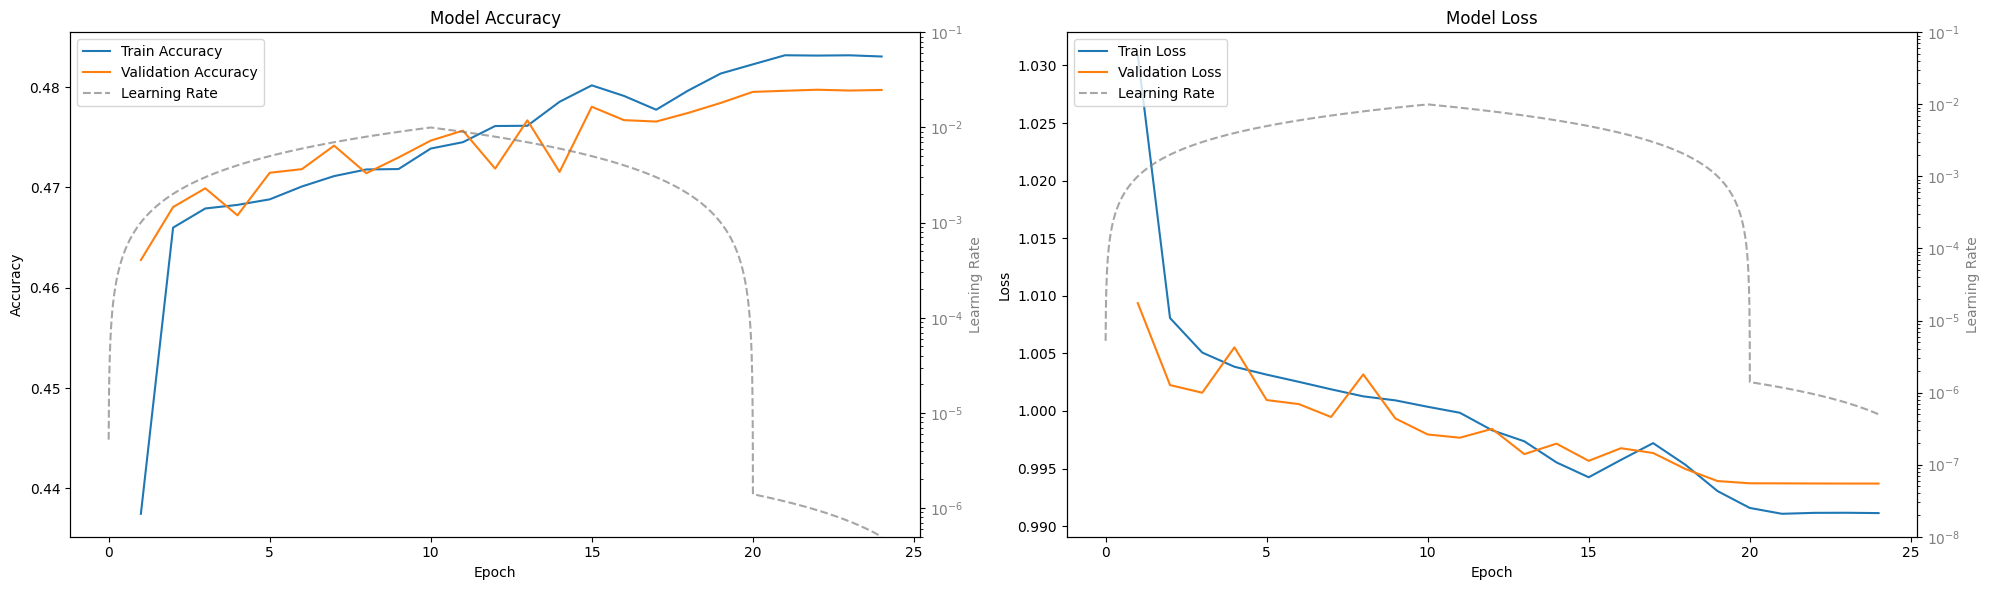

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'history' and 'cyclic_lr' are defined from your model training
epochs = range(1, len(history.history['accuracy']) + 1)
batch_indices = np.linspace(0, len(epochs), num=len(custom_clr.history['lr']))

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(20, 6))

# Plot accuracy
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy', color='C0')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='C1')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')

# Plot learning rate for accuracy subplot
ax2 = ax1.twinx()
ax2.plot(batch_indices, custom_clr.history['lr'], label='Learning Rate', color='grey', alpha=0.7, linestyle='--')
ax2.set_ylabel('Learning Rate', color='grey')
ax2.tick_params(axis='y', labelcolor='grey')
ax2.set_yscale('log')
ax2.set_ylim(5*1e-7, 1*1e-1)

# Create a unique legend for the accuracy plot that includes the learning rate
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Plot loss
ax3.plot(epochs, history.history['loss'], label='Train Loss', color='C0')
ax3.plot(epochs, history.history['val_loss'], label='Validation Loss', color='C1')
ax3.set_title('Model Loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')

# Plot learning rate for loss subplot
ax4 = ax3.twinx()
ax4.plot(batch_indices, custom_clr.history['lr'], label='Learning Rate', color='grey', alpha=0.7, linestyle='--')
ax4.set_ylabel('Learning Rate', color='grey')
ax4.tick_params(axis='y', labelcolor='grey')
ax4.set_yscale('log')
ax4.set_ylim(1*1e-8, 1*1e-1)

# Since ax3 (loss plot) already includes the learning rate, simply use its legend
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc='upper left')

plt.tight_layout()
plt.show()
